Video: 1920x1080, fps=25.0000
Tracked frames: 12
First 5: [[ 0.00000000e+00  8.85328270e+02  4.60360352e+02  1.43466050e+06
   1.75300000e+03  1.07900000e+03 -9.00000000e+01]
 [ 1.00000000e+00  8.86153586e+02  4.63572243e+02  1.47296100e+06
   1.78200000e+03  1.07900000e+03 -9.00000000e+01]
 [ 2.00000000e+00  8.87198578e+02  4.63348061e+02  1.45681850e+06
   1.75800000e+03  1.07900000e+03 -9.00000000e+01]
 [ 3.00000000e+00  8.89872123e+02  4.63820697e+02  1.46381450e+06
   1.75900000e+03  1.07900000e+03 -9.00000000e+01]
 [ 4.00000000e+00  8.90462696e+02  4.60672452e+02  1.49027300e+06
   1.81600000e+03  1.07900000e+03 -9.00000000e+01]]
frame gaps unique: [1]
cy range (px): 453.0933630433103 465.4824702545904 delta: 12.389107211280077
Kept frames after QC: 11 / 12
Lpx_ref(95%)=1802.00px -> scale=0.026693 mm/px


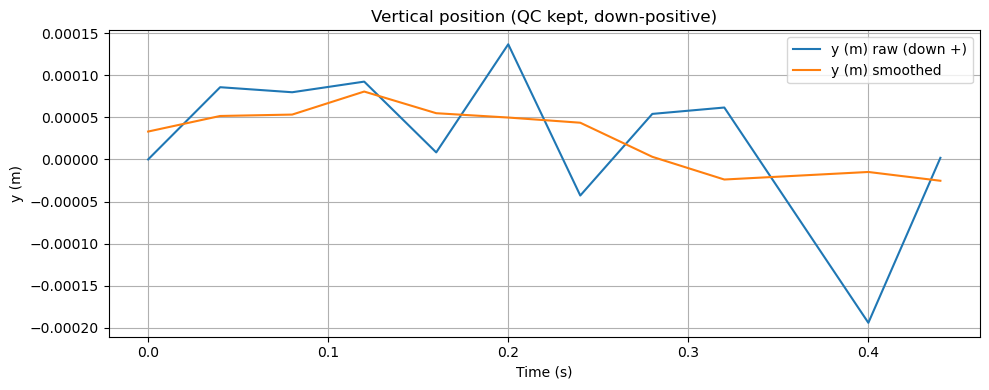

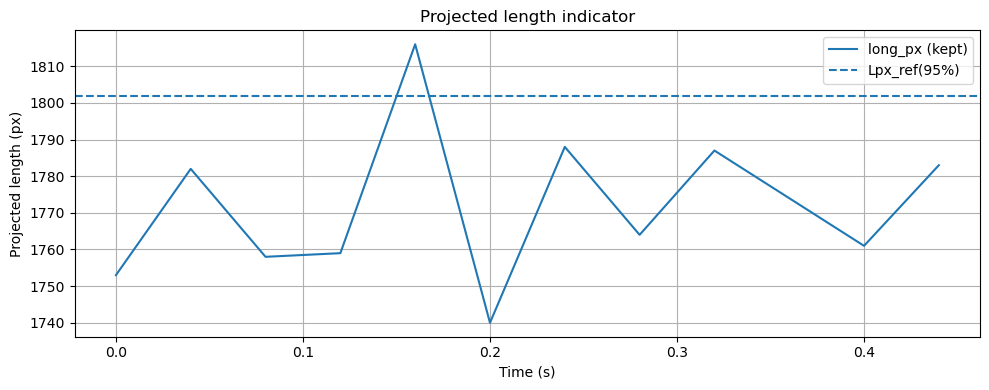

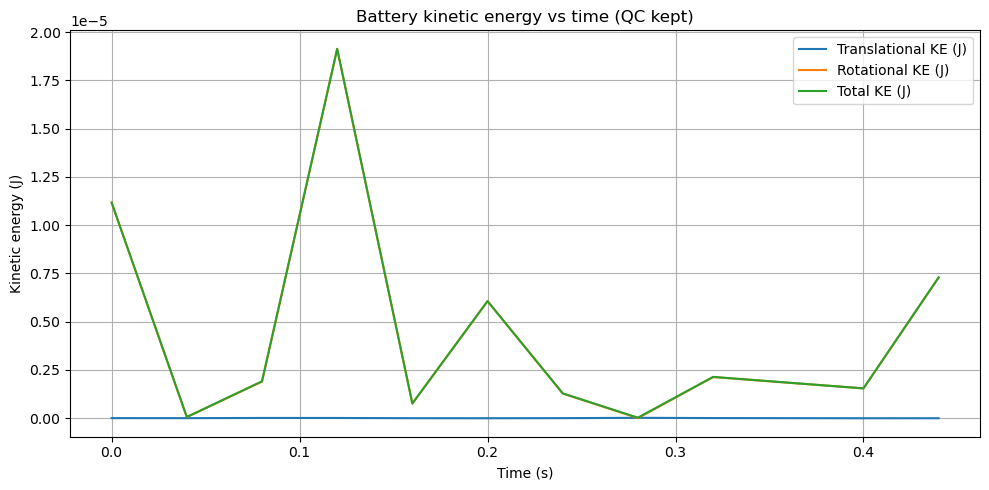

Done. Annotated video: (not saved)


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) 你要改的参数
# =========================
video_path = "/home/xuwentao/IPT-2026/cut-3.mp4"

# 电池真实尺寸（mm）
L_MM = 48.1   # 总长
D_MM = 16.0   # 直径

mass_kg = 0.0239  # 电池质量 (kg)

save_vis = False
annotated_path = "output_annotated.mp4"

# =========================
# 1) 分割参数（黑黄格）
# =========================
# 黄色 HSV（你图里偏橙黄：H 15~45 基本合适）
LOW_YELLOW  = np.array([15, 60, 60])
HIGH_YELLOW = np.array([45, 255, 255])

# 吸收黑格/端子：暗像素阈值（越大越“宽松”）
DARK_THRESH = 95

# 形态学核：格子碎 → 先闭运算粘起来，再开运算去噪
KERNEL_CLOSE = (13, 13)
KERNEL_OPEN  = (7, 7)

# 黄色邻域ROI：只在黄色附近吸黑，防止把纸边/背景黑物体吸进来
ROI_DILATE = (21, 21)

MIN_AREA = 300

# =========================
# 2) 小工具：移动平均（平滑位置，避免差分放大噪声）
# =========================
def moving_average(x, win=5):
    x = np.asarray(x, dtype=float)
    if win <= 1 or len(x) < 3:
        return x
    win = int(win)
    k = np.ones(win) / win
    xpad = np.pad(x, (win//2, win-1-win//2), mode="edge")
    return np.convolve(xpad, k, mode="valid")

# =========================
# 3) 读视频 + 跟踪（输出 records）
# records: (frame_idx, cx_px, cy_px, area, long_px, short_px, phi_deg)
# =========================
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {video_path}")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video: {w}x{h}, fps={fps:.4f}")

out = None
if save_vis:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(annotated_path, fourcc, fps, (w, h))

k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, KERNEL_CLOSE)
k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, KERNEL_OPEN)
k_roi   = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ROI_DILATE)

records = []
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 3.1 黄色种子
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask_y = cv2.inRange(hsv, LOW_YELLOW, HIGH_YELLOW)
    mask_y = cv2.morphologyEx(mask_y, cv2.MORPH_CLOSE, k_close, iterations=2)

    # 3.2 只在黄色附近吸收暗像素（黑格/端子）
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask_roi = cv2.dilate(mask_y, k_roi, iterations=1)

    mask_dark = (gray < DARK_THRESH).astype(np.uint8) * 255
    mask_dark = cv2.bitwise_and(mask_dark, mask_dark, mask=mask_roi)

    mask = cv2.bitwise_or(mask_y, mask_dark)

    # 3.3 清理：粘连 + 去噪
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k_open,  iterations=1)

    # 3.4 最大轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        frame_idx += 1
        continue

    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    if area < MIN_AREA:
        frame_idx += 1
        continue

    M = cv2.moments(cnt)
    if M["m00"] == 0:
        frame_idx += 1
        continue

    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]

    (rcx, rcy), (rw, rh), phi_deg = cv2.minAreaRect(cnt)
    long_px = max(rw, rh)
    short_px = min(rw, rh)

    records.append((frame_idx, cx, cy, area, long_px, short_px, phi_deg))

    if save_vis:
        vis = frame.copy()
        box = cv2.boxPoints(((rcx, rcy), (rw, rh), phi_deg))
        box = np.intp(box)
        cv2.drawContours(vis, [box], 0, (0, 255, 0), 2)
        cv2.circle(vis, (int(cx), int(cy)), 5, (0, 0, 255), -1)
        cv2.putText(vis, f"f={frame_idx} long={long_px:.1f}px",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        out.write(vis)

    frame_idx += 1

cap.release()
if out is not None:
    out.release()

if len(records) < 8:
    raise RuntimeError("Too few tracked frames. Tune HSV/DARK/ROI/MIN_AREA.")

records = np.array(records, dtype=float)
print("Tracked frames:", len(records))
print("First 5:", records[:5])

# =========================
# 4) 基础检查：帧连续性 & cy变化量
# =========================
f       = records[:, 0].astype(int)
cx_px   = records[:, 1]
cy_px   = records[:, 2]
area    = records[:, 3]
long_px = records[:, 4]
short_px= records[:, 5]
phi_deg = records[:, 6]

print("frame gaps unique:", np.unique(np.diff(f)))
print("cy range (px):", cy_px.min(), cy_px.max(), "delta:", cy_px.max()-cy_px.min())

# =========================
# 5) QC：只砍“离谱跳点”，不误杀自由落体
#    - 保留帧号连续
#    - 位移用 99 分位阈值（而不是MAD）
#    - area/long_px 做温和约束
# =========================
keep_contig = np.hstack([True, np.diff(f) == 1])

dx = np.diff(cx_px, prepend=cx_px[0])
dy = np.diff(cy_px, prepend=cy_px[0])
disp = np.sqrt(dx*dx + dy*dy)

# 只砍最离谱的 1% 跳点（你也可改 98/99.5）
thr = np.percentile(disp[keep_contig], 99)
keep_disp = disp <= thr

area_med = np.median(area[keep_contig])
long_med = np.median(long_px[keep_contig])

keep_area = (area > 0.4*area_med) & (area < 2.5*area_med)
keep_long = (long_px > 0.5*long_med) & (long_px < 1.6*long_med)

keep = keep_contig & keep_disp & keep_area & keep_long

print("Kept frames after QC:", int(np.sum(keep)), "/", len(records))
if np.sum(keep) < 8:
    print("QC too strict. Try: lower MIN_AREA, change thr percentile to 99.5, or widen keep_area/keep_long.")

# 用筛后的数据
f2       = f[keep]
cx2      = cx_px[keep]
cy2      = cy_px[keep]
long2    = long_px[keep]
phi2_deg = phi_deg[keep]

t2 = f2 / float(fps)

# =========================
# 6) 标定：用电池总长 48.1mm 对应 long_px 的 95分位
# =========================
Lpx_ref = np.percentile(long2[long2 > 1e-6], 95)
mm_per_px = L_MM / Lpx_ref
m_per_px  = mm_per_px / 1000.0
print(f"Lpx_ref(95%)={Lpx_ref:.2f}px -> scale={mm_per_px:.6f} mm/px")

# 坐标：向下为正，并从0开始（自由落体应单调增加）
x2 = (cx2 - cx2[0]) * m_per_px
y2 = (cy2 - cy2[0]) * m_per_px

# 平滑后差分
x2s = moving_average(x2, win=5)
y2s = moving_average(y2, win=5)

# =========================
# 7) 动能：平动 + 转动（简化）
# =========================
vx2 = np.gradient(x2s, t2)
vy2 = np.gradient(y2s, t2)
KE_trans = 0.5 * mass_kg * (vx2*vx2 + vy2*vy2)

# 角速度：平面内 + “投影缩短”倾角
phi2 = np.unwrap(np.deg2rad(phi2_deg))
omega_inplane = np.gradient(phi2, t2)

ratio = np.clip(long2 / Lpx_ref, 0.0, 1.0)
theta = np.arccos(ratio)
omega_tilt = np.gradient(theta, t2)

r = (D_MM/2)/1000.0
L = (L_MM)/1000.0
I_perp = (1/12) * mass_kg * (3*r*r + L*L)

KE_rot = 0.5 * I_perp * (omega_inplane**2 + omega_tilt**2)
KE_total = KE_trans + KE_rot

# =========================
# 8) 画图：y(t), long_px(t), KE(t)
# =========================
plt.figure(figsize=(10,4))
plt.plot(t2, y2,  label="y (m) raw (down +)")
plt.plot(t2, y2s, label="y (m) smoothed")
plt.xlabel("Time (s)")
plt.ylabel("y (m)")
plt.title("Vertical position (QC kept, down-positive)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t2, long2, label="long_px (kept)")
plt.axhline(Lpx_ref, ls="--", label="Lpx_ref(95%)")
plt.xlabel("Time (s)")
plt.ylabel("Projected length (px)")
plt.title("Projected length indicator")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(t2, KE_trans, label="Translational KE (J)")
plt.plot(t2, KE_rot,   label="Rotational KE (J)")
plt.plot(t2, KE_total, label="Total KE (J)")
plt.xlabel("Time (s)")
plt.ylabel("Kinetic energy (J)")
plt.title("Battery kinetic energy vs time (QC kept)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

print("Done.", "Annotated video:" , annotated_path if save_vis else "(not saved)")


fps=25.0000
Valid tracked frames: 12
Frame gaps unique: [1]
long_px: median=1773.00px, 5%=1747.15px, 95%=1816.90px, min=1740.00, max=1818.00
short_px: median=1079.00px, 5%=1079.00px, 95%=1079.00px, min=1079.00, max=1079.00
area: median=1460419.75px, 5%=1432685.45px, 95%=1480751.40px, min=1430271.50, max=1490273.00
aspect long/short: median=1.64px, 5%=1.62px, 95%=1.68px, min=1.61, max=1.68


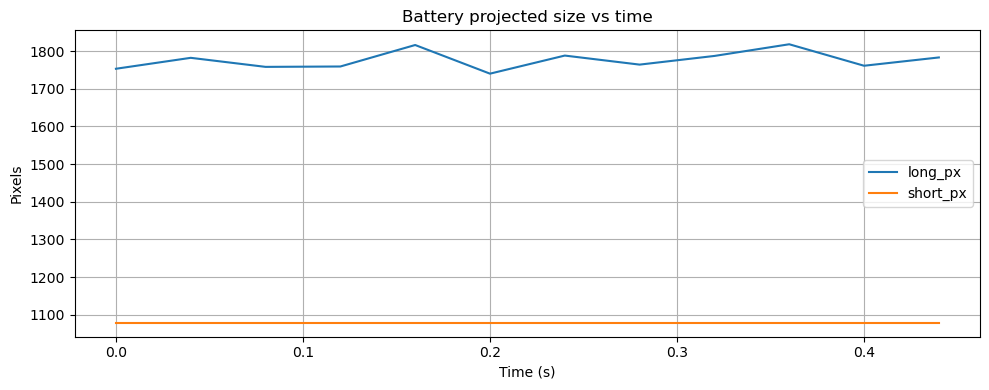

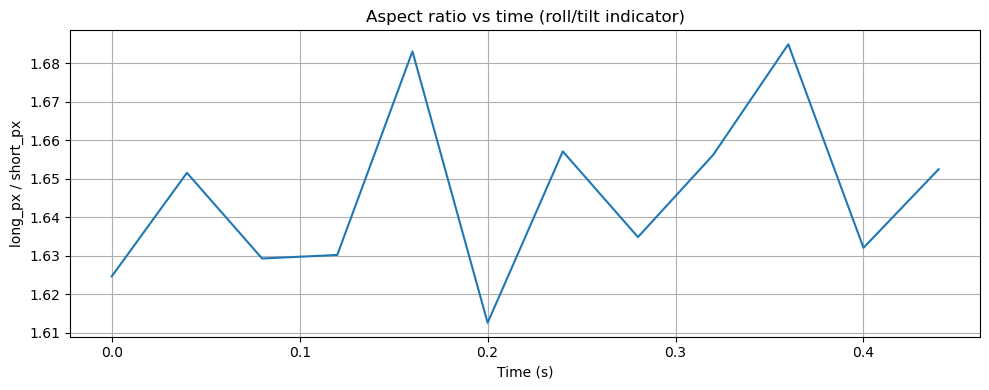

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ========== 改这里 ==========
video_path = "/home/xuwentao/IPT-2026/cut-3.mp4"

# 黑黄格分割参数（和你之前一致）
LOW_YELLOW  = np.array([15, 60, 60])
HIGH_YELLOW = np.array([45, 255, 255])
DARK_THRESH = 95

KERNEL_CLOSE = (13, 13)
KERNEL_OPEN  = (7, 7)
ROI_DILATE   = (21, 21)

MIN_AREA = 300
# ===========================

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {video_path}")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
print(f"fps={fps:.4f}")

k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, KERNEL_CLOSE)
k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, KERNEL_OPEN)
k_roi   = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ROI_DILATE)

rows = []  # (frame_idx, t, long_px, short_px, area)

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 1) 黄块
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask_y = cv2.inRange(hsv, LOW_YELLOW, HIGH_YELLOW)
    mask_y = cv2.morphologyEx(mask_y, cv2.MORPH_CLOSE, k_close, iterations=2)

    # 2) 仅在黄附近吸暗像素（黑格/端子）
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask_roi = cv2.dilate(mask_y, k_roi, iterations=1)

    mask_dark = (gray < DARK_THRESH).astype(np.uint8) * 255
    mask_dark = cv2.bitwise_and(mask_dark, mask_dark, mask=mask_roi)

    mask = cv2.bitwise_or(mask_y, mask_dark)

    # 3) 清理
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k_open,  iterations=1)

    # 4) 最大轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        frame_idx += 1
        continue

    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    if area < MIN_AREA:
        frame_idx += 1
        continue

    # 5) 旋转矩形尺寸（像素）
    (rcx, rcy), (rw, rh), phi = cv2.minAreaRect(cnt)
    long_px = float(max(rw, rh))
    short_px = float(min(rw, rh))

    t = frame_idx / float(fps)
    rows.append((frame_idx, t, long_px, short_px, float(area)))

    frame_idx += 1

cap.release()

if len(rows) < 5:
    raise RuntimeError("Too few valid frames. Try tuning HSV/DARK/ROI/MIN_AREA.")

rows = np.array(rows, dtype=float)
f = rows[:,0].astype(int)
t = rows[:,1]
long_px = rows[:,2]
short_px = rows[:,3]
area = rows[:,4]

# ========== 统计 ==========
def stats(name, x):
    p = np.percentile(x, [5, 50, 95])
    print(f"{name}: median={p[1]:.2f}px, 5%={p[0]:.2f}px, 95%={p[2]:.2f}px, min={x.min():.2f}, max={x.max():.2f}")

print("Valid tracked frames:", len(rows))
print("Frame gaps unique:", np.unique(np.diff(f)))
stats("long_px", long_px)
stats("short_px", short_px)
stats("area", area)

# 长宽比（看翻滚/姿态变化很直观）
aspect = long_px / np.maximum(short_px, 1e-6)
stats("aspect long/short", aspect)

# ========== 画图 ==========
plt.figure(figsize=(10,4))
plt.plot(t, long_px, label="long_px")
plt.plot(t, short_px, label="short_px")
plt.xlabel("Time (s)")
plt.ylabel("Pixels")
plt.title("Battery projected size vs time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, aspect)
plt.xlabel("Time (s)")
plt.ylabel("long_px / short_px")
plt.title("Aspect ratio vs time (roll/tilt indicator)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import cv2
cap = cv2.VideoCapture("/home/xuwentao/IPT-2026/test-videos/cut-05.mov")
print(cap.isOpened())


True
